残差块

```
nn.Conv2d 中，前两个参数分别是：
第一个参数：in_channels（输入通道数）
第二个参数：out_channels（输出通道数）

In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

class Residual(nn.Module):
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels,num_channels,
                               kernel_size=3,padding=1,stride=strides)
        self.conv2 = nn.Conv2d(num_channels,num_channels,
                               kernel_size=3,padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels,num_channels,
                                   kernel_size=1,stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        #F是前面定义的torch.nn.functional模块别名
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

```
下面我们来查看输入和输出形状一致的情况。
创建一个随机张量作为输入，形状是 `[4, 3, 6, 6]`：
- `4`：批量大小（batch size）- 一次处理4张图片
- `3`：通道数 - RGB三个通道
- `6, 6`：图片的高度和宽度都是6像素

In [2]:
blk = Residual(3,3)
X = torch.rand(4, 3, 6, 6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

```
  # 第1步：conv1 + bn1 + relu
    X → conv1 → [4, 6, 3, 3]  # 3→6通道，stride=2使尺寸减半 (6/2=3)
  # 第2步：conv2 + bn2
    Y → conv2 → [4, 6, 3, 3]  # 6→6通道，stride=1(默认)保持尺寸
  # 第3步：调整原始输入X  
  X → conv3 → [4, 6, 3, 3]  # 1×1卷积：3→6通道，stride=2使尺寸减半  

In [3]:
blk = Residual(3,6, use_1x1conv=True, strides=2)
blk(X).shape

torch.Size([4, 6, 3, 3])

 ResNet模型

ResNet的前两层跟之前介绍的GoogLeNet中的一样： 在输出通道数为64、步幅为2的7×7卷积层后，接步幅为2的3×3的最大汇聚层。 不同之处在于ResNet每个卷积层后增加了批量规范化层。

b1 是 ResNet 网络的第一个构建块，也叫做 stem 或 initial block

In [4]:
b1 = nn.Sequential(nn.Conv2d(1,64,kernel_size=7,stride=2,padding=3),
                  nn.BatchNorm2d(64),nn.ReLU(),
                  nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

ResNet则使用4个由残差块组成的模块，每个模块使用若干个同样输出通道数的残差块。下面我们来实现这个模块。注意，我们对第一个模块做了特别处理。

In [5]:
def resnet_block(input_channels,num_channels,num_residuals,first_block=False):
    blk = []
    for i in range(num_residuals):
        if i == 0 and not first_block:
            #调整维度：每组的第一个残差块（除了最开始的第一组）
            blk.append(Residual(input_channels,num_channels,use_1x1conv=True, strides=2))   # 添加残差块到列表
        else:
            blk.append(Residual(num_channels,num_channels))
    return blk

接着在ResNet加入所有残差块，这里每个模块使用2个残差块。2->num_residuals

In [6]:
# *符号是 Python 中的解包操作符（unpacking operator）
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))
b3 = nn.Sequential(*resnet_block(64, 128, 2))
b4 = nn.Sequential(*resnet_block(128, 256, 2))
b5 = nn.Sequential(*resnet_block(256, 512, 2))

最后，与GoogLeNet一样，在ResNet中加入全局平均汇聚层，以及全连接层输出。

In [7]:
net = nn.Sequential(b1, b2, b3, b4, b5,
                    nn.AdaptiveAvgPool2d((1,1)),
                    nn.Flatten(), nn.Linear(512, 10))

在训练ResNet之前，让我们观察一下ResNet中不同模块的输入形状是如何变化的。 在之前所有架构中，分辨率降低，通道数量增加，直到全局平均汇聚层聚集所有特征。

```
X = torch.rand(size=(1, 1, 224, 224))
# [batch_size=1, channels=1, height=224, width=224]
# 1张224×224的灰度图像
第1层：Sequential (b1 - stem block)
b1 = nn.Sequential(
    nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),  # 224→112, 1→64通道 
    nn.BatchNorm2d(64),
    nn.ReLU(), 
    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)       # 112→56
)
输入: [1, 1, 224, 224] → 输出: [1, 64, 56, 56]

```
#if blk.append(Residual(input_channels,num_channels,use_1x1conv=True, strides=2))
#可以看到b3,b3,b5的步长都是2
第2层：Sequential (b2 - 第1个残差块组)
else:blk.append(Residual(64, 64))  # ✅ 执行这个分支，使用默认参数！
输入: [1, 64, 56, 56] → 输出: [1, 64, 56, 56]    
第3层：Sequential (b3 - 第2个残差块组)
输入: [1, 64, 56, 56] → 输出: [1, 128, 28, 28]  
第4层：Sequential (b4 - 第3个残差块组)
输入: [1, 128, 28, 28] → 输出: [1, 256, 14, 14]  
第5层：Sequential (b5 - 第4个残差块组)
输入: [1, 256, 14, 14] → 输出: [1, 512, 7, 7]  
第6层：AdaptiveAvgPool2d
#AdaptiveAvgPool2d 是自适应平均池化，它的作用是将任意尺寸的特征图池化到指定的输出尺寸。
#nn.AdaptiveAvgPool2d((1,1))
输入: [1, 512, 7, 7] → 输出: [1, 512, 1, 1]  

In [8]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


```
为什么是ResNet-18
b2 = nn.Sequential(*resnet_block(64, 64, 2, first_block=True))   # 2个residual blocks
b3 = nn.Sequential(*resnet_block(64, 128, 2))                    # 2个residual blocks  
b4 = nn.Sequential(*resnet_block(128, 256, 2))                   # 2个residual blocks
b5 = nn.Sequential(*resnet_block(256, 512, 2))                   # 2个residual blocks
总共：2+2+2+2 = 8个residual blocks
----
class Residual(nn.Module):
    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))  # conv1: 第1个卷积层
        Y = self.bn2(self.conv2(Y))          # conv2: 第2个卷积层
        # ...
每个block有2个卷积层，所以16个卷积层
加上第一层conv和最后fc层 ≈ 18层网络

训练模型


KeyboardInterrupt



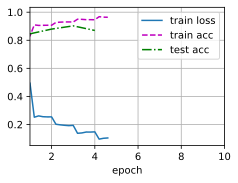

In [9]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())